### Assignment 3: Graph Visualization

#### Summer 2021
**Authors:** GOAT Team (Estaban Aramayo, Ethan Haley, Claire Meyer, and Tyler Frankenburg) 

This assignment looks at a CSV of Donor + Donor Recipient Data from OpenSecret, which tracks political donations.

This particular dataset tracks the donation total during the 2020 election cycle from individuals, companies, and PACs/Super PACs to the 148 members of congress who objected to certification of 2020 Electoral College results in January 2021.

This data is available [here](https://docs.google.com/spreadsheets/d/1PPjz-U1LueQYHaVCU8iCYf3O4lc-OYN7uOf3OknhYxo/edit#gid=1325242852). 


In [27]:
import networkx as nx
import pandas
import matplotlib.pyplot as plt
from pyvis.network import Network
import warnings
warnings.filterwarnings('ignore')

First we import the CSV and do a couple quick checks to see the shape and form of the data. 

In [2]:
df = pandas.read_csv('https://raw.githubusercontent.com/ebhtra/gory-graph/main/politicalDonations/donor_members.csv')
df.head()

PAC        CID           CRPName Distid    Total  \
0  American Medical Assn  N00025219  Burgess, Michael   TX26  $20,000   
1  American Medical Assn  N00028152   McCarthy, Kevin   CA23  $20,000   
2   American Dental Assn  N00005736      Babin, Brian   TX36  $20,000   
3   American Dental Assn  N00025219  Burgess, Michael   TX26  $20,000   
4   American Dental Assn  N00035346     Carter, Buddy   GA01  $17,500   

   Unnamed: 5                                         Unnamed: 6  
0         NaN                                                NaN  
1         NaN  Direct contributions data covers the 2020 elec...  
2         NaN                                                NaN  
3         NaN                                                NaN  
4         NaN                                                NaN

In [3]:
df.shape

(2686, 7)

Convert the `Total` (donation) column to integer

In [4]:
df.Total = [int(''.join(c for c in donation if str.isnumeric(c))) for donation in df.Total]
print(f'Donations range from {min(df.Total)} to {max(df.Total)} dollars.')

Donations range from 10000 to 30000 dollars.


Then, we use the `from_pandas_dataframe` function to create a networkx graph from the dataframe. [Source](https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.convert_matrix.from_pandas_dataframe.html). 

In [35]:
G = nx.from_pandas_dataframe(df, source="PAC", target="CRPName",
                                  edge_attr=["Total"])

In [36]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 712
Number of edges: 2675
Average degree:   7.5140


For this assignment we want to explore diameter. However, diameter requires a connected graph. First, let's check if this graph is, with the `is_connected` function. [Source](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.is_connected.html#networkx.algorithms.components.is_connected).

In [37]:
print(nx.is_connected(G))

False


This graph is not connected. We can look for subgraphs that are however, and focus measurement there. The `connected_component_subgraphs` function generates any available connected subgraphs. [Source](https://networkx.org/documentation/networkx-1.9.1/reference/generated/networkx.algorithms.components.connected.connected_component_subgraphs.html).

In [38]:
graphs = list(nx.connected_component_subgraphs(G))
print("There are", len(graphs), "connected subgraphs in this graph.")

There are 2 connected subgraphs in this graph.


Let's compare the size of these subgraphs by the number of nodes.

In [39]:
print("The first subgraph has",len(graphs[0].nodes()),"nodes.")
print("The second subgraph has",len(graphs[1].nodes()),"nodes.")

The first subgraph has 710 nodes.
The second subgraph has 2 nodes.


Let's select the larger of the two, and explore further.



In [40]:
G = graphs[0]
colors = ['lightgreen' if node in df.CRPName.values else 'violet' for node in G]
        
#node colors adapted from source: https://stackoverflow.com/a/59473049

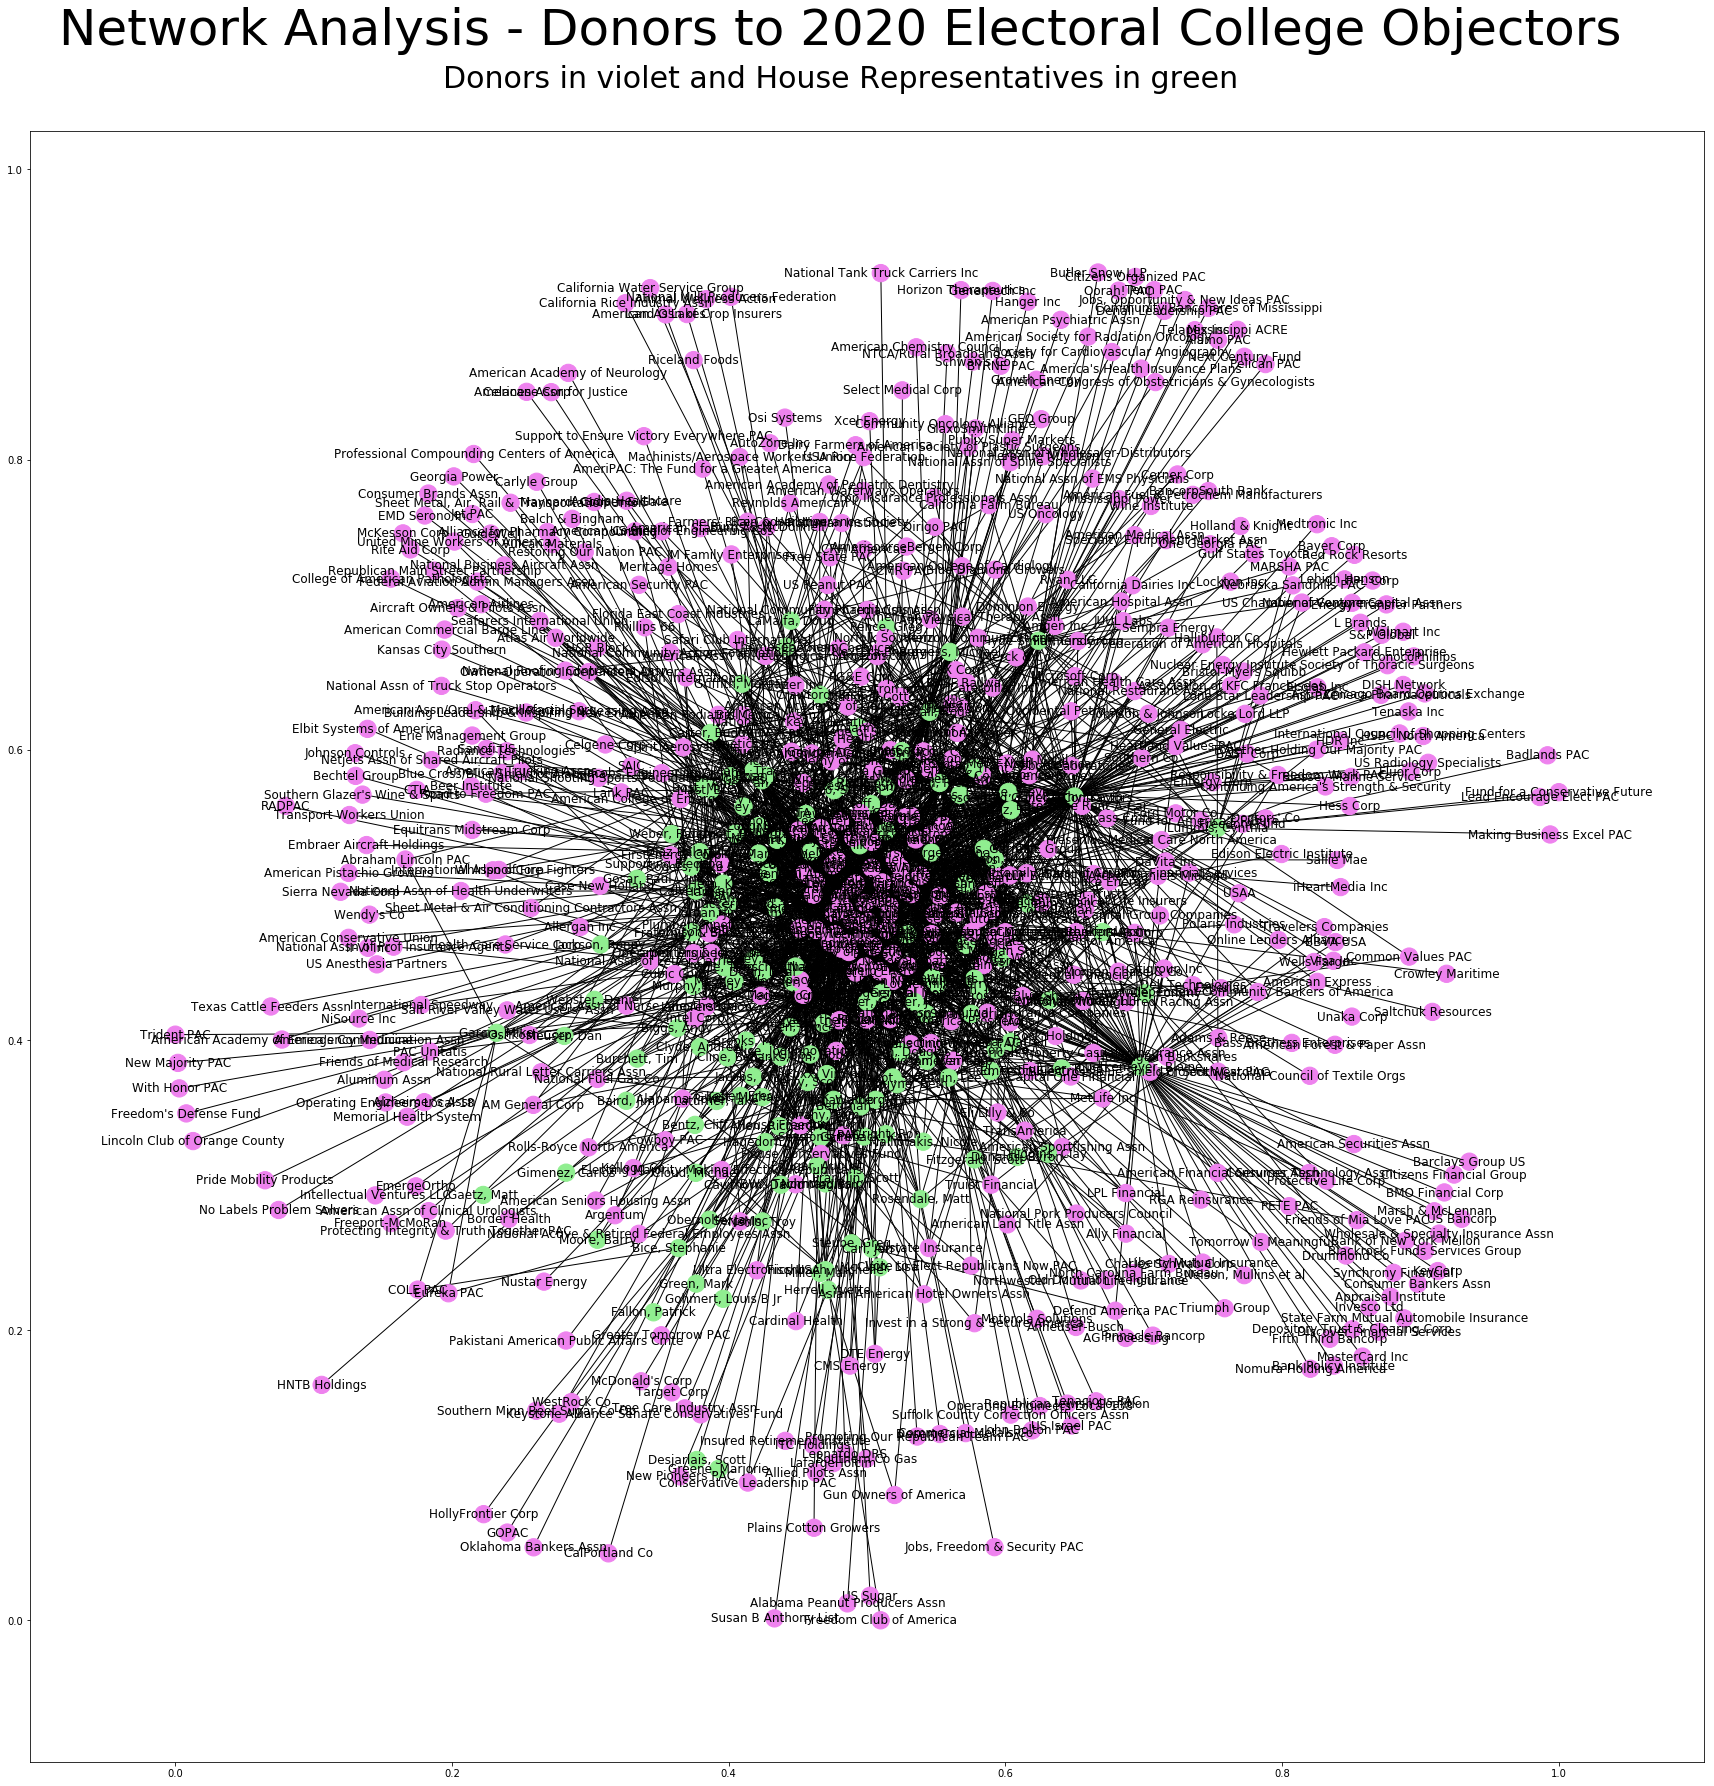

In [41]:
plt.figure(figsize = (30, 30))
ax = plt.subplot()

nx.draw_networkx(G, ax=ax, node_color=colors)

plt.figtext(.5,.92,'Network Analysis - Donors to 2020 Electoral College Objectors', fontsize=50, ha='center')
plt.figtext(.5,.9, 'Donors in violet and House Representatives in green', fontsize = 30, ha='center')
plt.show()

#### The same graph, interactively, in pyvis:

In [33]:
sgt_net = Network(height='750px', width='100%', bgcolor='#222222', font_color='white', heading="Donors to Electoral College Objectors, 2020 Cycle", notebook=False)

# set the physics layout of the network
sgt_net.barnes_hut()

sources = df['PAC']
targets = df['CRPName']

edge_data = zip(sources, targets)

for e in edge_data:
    src = e[0]
    dst = e[1]
    
    sgt_net.add_node(src, src, title=src, color='violet')
    sgt_net.add_node(dst, dst, title=dst, color='lightgreen')
    sgt_net.add_edge(src, dst)

neighbor_map = sgt_net.get_adj_list()

# add neighbor data to node hover data
for node in sgt_net.nodes:
    node['title'] += ' Neighbors:<br>' + '<br>'.join(neighbor_map[node['id']])
    node['value'] = len(neighbor_map[node['id']])

#sgt_net.show_buttons()  #to use, must comment out `set options` code below

#options JSON string can be pasted into set.options() from dynamic editor after running the html with show_buttons() above
sgt_net.set_options("""
var options = {
  "nodes": {
    "borderWidth": 0
  },
  "edges": {
    "color": {
      "color": "rgba(25,148,150,1)",
      "highlight": "rgba(210,254,255,1)",
      "hover": "rgba(29,225,229,1)",
      "inherit": false
    },
    "smooth": false
  },
  "physics": {
    "barnesHut": {
      "gravitationalConstant": -80000,
      "springLength": 150,
      "springConstant": 0.001
    },
    "maxVelocity": 20,
    "minVelocity": 0.75
  }
}""")

#sgt_net.show('political_donations.html') #writes the local html file, and launches in browser


In [34]:
from IPython.display import IFrame

IFrame('https://curdferguson.github.io/gory-graph/', width=1000, height=1000) #this version is a demo hosted on github rep curdferguson/gory-graph branch TFpyvis

We can use the built in diameter function to determine the diameter of this subgraph.

In [12]:
diameter_test = nx.diameter(G)

print("The diameter is: ", diameter_test)

The diameter is:  6


The first thing that jumps out of the confusion of the graph is that a large proportion of the nodes are Donors who only contribute to one or maybe two Representatives, in other words special interest groups who don't serve much purpose here other than muddling the picture.  So let's see how things look without them.

In [13]:
pacs = set(df.PAC)
# remove donors with fewer than 3 donations
minors = {pac for pac in pacs if pac in G and len(G[pac]) < 3}
len(minors)

352

In [14]:
majors = G.subgraph(set(G.nodes()) - minors)
len(majors)

358

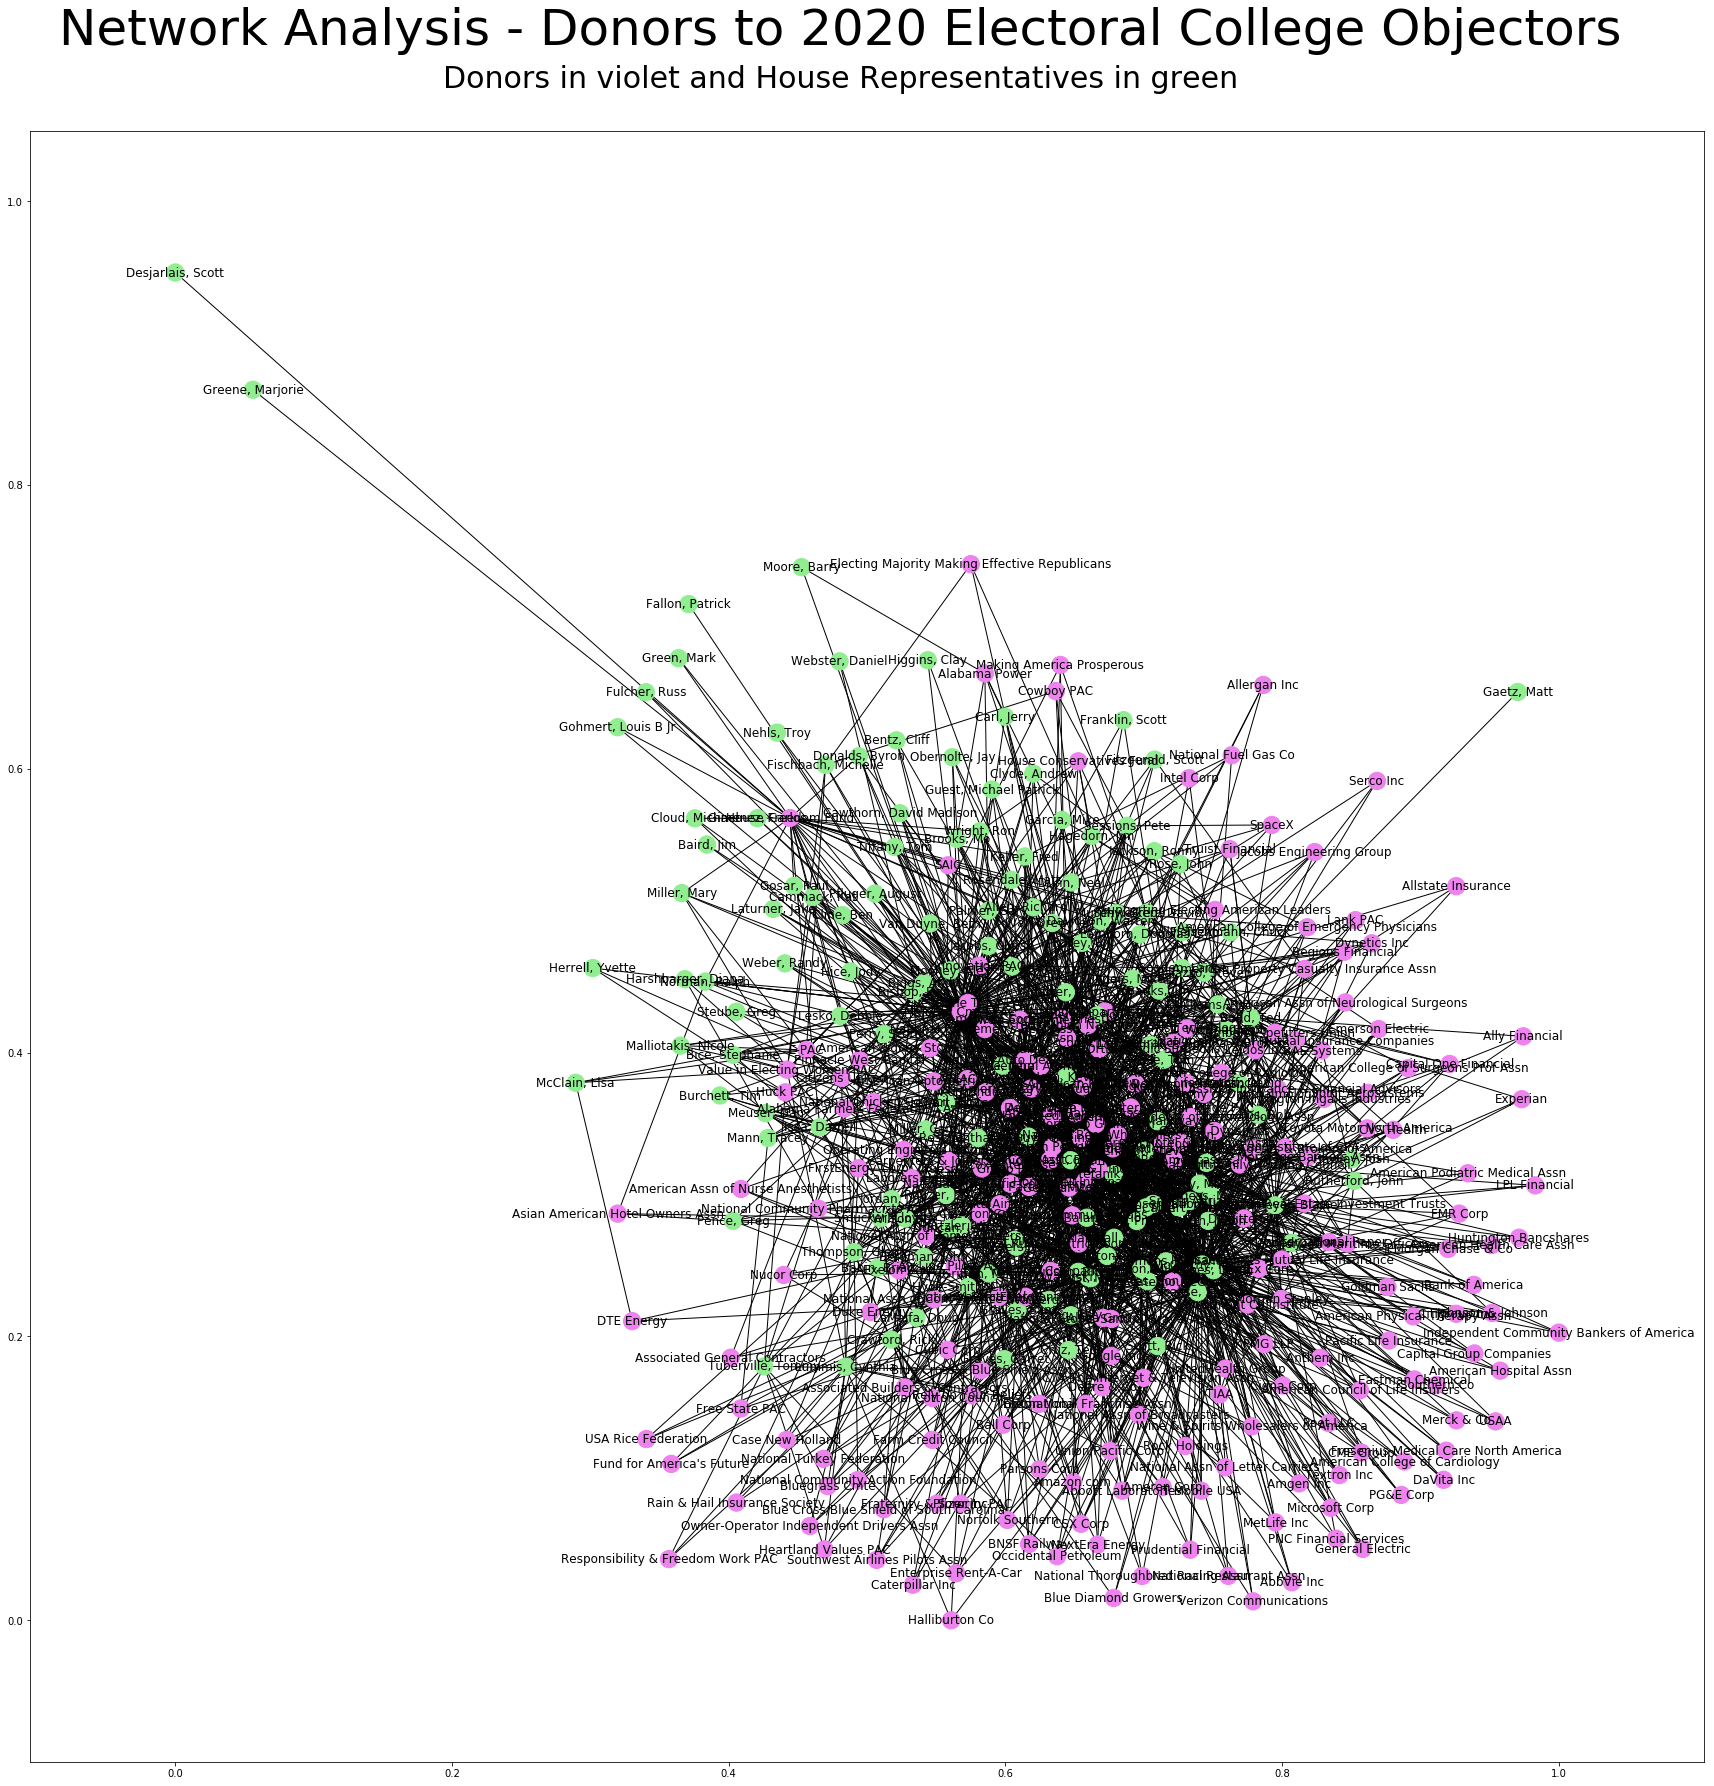

In [31]:
colors = ['lightgreen' if node in df.CRPName.values else 'violet' for node in majors]

plt.figure(figsize = (30, 30))
ax = plt.subplot()

nx.draw_networkx(majors, ax=ax, node_color=colors)

plt.figtext(.5,.92,'Network Analysis - Donors to 2020 Electoral College Objectors', fontsize=50, ha='center')
plt.figtext(.5,.9, 'Donors in violet and House Representatives in green', fontsize = 30, ha='center')
plt.show()

In [16]:
nx.diameter(majors)

5

We can also look at top nodes based on some of our centrality measures, e.g. degree centrality, closeness, and betweenness. We start by pulling the sorted_map function from [the textbook's repo](https://www.oreilly.com/library/view/social-network-analysis/9781449311377/), then using different NetworkX built in centrality functions. 

In [17]:
def sorted_map(dd: dict) -> dict:
    """
    Sorts dict by its values (desc)
    
    :param dd: dictionary with numeric values
    :return sorted dictionary ordered by its numeric value
    """
    sorted_dict = sorted(dd.items(), key=lambda x: (-x[1], x[0]))
    sorted_dict = [(x[0], round(x[1], 2)) for x in sorted_dict]
    return sorted_dict

In [18]:
d_major = nx.degree_centrality(majors)
dsm = sorted_map(d_major)
dsm[:10]

[('Majority Cmte PAC', 0.34),
 ('McCarthy, Kevin', 0.32),
 ('Scalise, Steve', 0.24),
 ('American Bankers Assn', 0.19),
 ('Stefanik, Elise', 0.17),
 ('National Auto Dealers Assn', 0.17),
 ('Hudson, Richard', 0.17),
 ('Luetkemeyer, Blaine', 0.16),
 ('National Assn of Realtors', 0.16),
 ('Koch Industries', 0.14)]

In [19]:
c_major = nx.closeness_centrality(majors)
csm = sorted_map(c_major)
csm[:10]

[('Majority Cmte PAC', 0.57),
 ('McCarthy, Kevin', 0.49),
 ('American Bankers Assn', 0.49),
 ('National Auto Dealers Assn', 0.48),
 ('National Assn of Realtors', 0.47),
 ('Comcast Corp', 0.46),
 ('Koch Industries', 0.46),
 ('American Crystal Sugar', 0.46),
 ('Scalise, Steve', 0.46),
 ('AT&T Inc', 0.45)]

In [20]:
b_major = nx.betweenness_centrality(majors)
bsm = sorted_map(b_major)
bsm[:10]

[('Majority Cmte PAC', 0.2),
 ('McCarthy, Kevin', 0.14),
 ('Scalise, Steve', 0.08),
 ('Stefanik, Elise', 0.05),
 ('American Bankers Assn', 0.05),
 ('National Auto Dealers Assn', 0.05),
 ('Hudson, Richard', 0.04),
 ('National Assn of Realtors', 0.04),
 ('Luetkemeyer, Blaine', 0.04),
 ('Koch Industries', 0.03)]

There are some consistent names across all 3.  Who are the 'elite group' across the 3 centrality metrics?  

It's not particularly surprising given the nature of his job as the leader of his caucus that House Minority Leader Kevin McCarthy ranks either 1 or 2 in each category.  He shares the top two spots with Majority Cmte PAC, a so-called leadership PAC with which he is directly affiliated, which raises money for the campaigns of other Republican House members.  

#### If we sum up the 3 centrality measures, we get a single number to rank centrality

In [21]:
names1 = [x[0] for x in dsm[:15]]
names2 = [x[0] for x in csm[:15]]
names3 = [x[0] for x in bsm[:15]]
names = list(set(names1) | set(names2) | set(names3))

summary_df = pandas.DataFrame({'Name': names, 
    'Degree Centrality': [d_major[name] for name in names],
    'Closeness': [c_major[name] for name in names], 
    'Betweenness': [b_major[name] for name in names]})


summary_df['Sum Centrality'] = sum([summary_df['Degree Centrality'],
                                   summary_df.Closeness,
                                   summary_df.Betweenness])

print('\n\n====== Most Central Nodes After Removing Isolated Donors ======')
summary_df.sort_values(by='Sum Centrality', ascending=False)



====== Most Central Nodes After Removing Isolated Donors ======


Name  Degree Centrality  Closeness  Betweenness  \
14           Majority Cmte PAC           0.338936   0.572115     0.195454   
3              McCarthy, Kevin           0.322129   0.494460     0.144771   
2               Scalise, Steve           0.243697   0.456522     0.079503   
4        American Bankers Assn           0.187675   0.491736     0.050373   
10  National Auto Dealers Assn           0.168067   0.482432     0.045566   
17   National Assn of Realtors           0.156863   0.474734     0.042847   
5              Stefanik, Elise           0.170868   0.440741     0.052366   
0              Hudson, Richard           0.165266   0.436430     0.043135   
9              Koch Industries           0.142857   0.462435     0.034187   
15         Luetkemeyer, Blaine           0.156863   0.434307     0.038881   
13                Comcast Corp           0.137255   0.462435     0.027931   
11      American Crystal Sugar           0.128852   0.461240     0.030090   
8                  Graves, Sam           0.128852   0.423990     0.033517   
1                     AT&T Inc           0.106443   0.450758     0.016320   
7                  Zeldin, Lee           0.123249   0.420991     0.026282   
16             Marshall, Roger           0.128852   0.408467     0.029639   
12            Northrop Grumman           0.086835   0.435366     0.013066   
6            Hyde-Smith, Cindy           0.098039   0.403846     0.027590   
18  Credit Union National Assn           0.081232   0.432203     0.014332   

    Sum Centrality  
14        1.106505  
3         0.961360  
2         0.779722  
4         0.729784  
10        0.696066  
17        0.674444  
5         0.663976  
0         0.644831  
9         0.639480  
15        0.630050  
13        0.627621  
11        0.620182  
8         0.586359  
1         0.573520  
7         0.570522  
16        0.566957  
12        0.535267  
6         0.529475  
18        0.527768

The top 3 recipients are, in order, the top 3 current House Republicans, Kevin McCarthy, Steve Scalise, and Elise Stefanik.  Stefanik was only voted into the 3rd spot quite recently, after these donations were made, replacing the previous 3rd in power, Liz Cheney, who has been outspoken in her opposition to the electoral roadblock these 148 Congressmen imposed.  So it's fair to say the votes followed the money, in this case.

In [22]:
print(nx.info(majors))

Name: 
Type: Graph
Number of nodes: 358
Number of edges: 2209
Average degree:  12.3408


The nodes in the graph are highly connected, with an average degree of over 12. Let's see how those degrees are distributed.

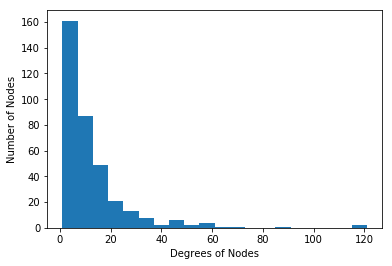

In [23]:
plt.hist([len(majors[n]) for n in majors], bins=20)
plt.xlabel('Degrees of Nodes')
plt.ylabel('Number of Nodes');

### Let's see if any new relationships emerge from making the graph bipartite

In [24]:
from networkx.algorithms import bipartite

# separates pols from PACs
pols = set(df.CRPName)
pacs = set(df.PAC)

bip = nx.Graph()
bip.add_nodes_from(pols, bipartite='Rep')
bip.add_nodes_from(pacs, bipartite='PAC')

bip.add_weighted_edges_from(zip(df.CRPName, df.PAC, df.Total), weight='donation')
# trim the isolated donors
bip.remove_nodes_from(minors)

In [25]:
Rep_proj = bipartite.weighted_projected_graph(bip, pols)

In [26]:
#nx.write_graphml(Rep_proj, 'Rep_proj.graphml')

#### Here is the weighted bipartite projection onto the House Reps, with nodes colored by betweenness.  
The thicker edges still show the most central figures receiving the most donations from common donors.  
The darker nodes have higher betweenness centrality now, however, and we can see that Bill Posey of Florida is much more "between" than Kevin McCarthy.  This perhaps suggests that he has a more central ideological role, or connects multiple groups of House Reps.

<img src="https://raw.githubusercontent.com/ebhtra/gory-graph/main/politicalDonations/BipartiteOnRepsWithBetweenness.png" width="1060" height="360">

[Link to presentation of this notebook on YouTube](https://youtu.be/LbfXn9PWcKg)